# Loan Approval Prediction
**Goal:** Predict whether a loan application will be approved or not based on applicant information.

**Dataset:** Home Loan Approval dataset with 615 records and 13 features.

## Task 1: Data Loading

In [28]:
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn preprocessing

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

#Classification models

from sklearn.ensemble import RandomForestClassifier

#metrics

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [29]:
# load the dataset
df = pd.read_csv("data.csv")

In [30]:
# display first few rows to verify data loaded correctly
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [31]:
# check the shape of the dataset
print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Dataset shape: (614, 13)
Rows: 614, Columns: 13


In [32]:
# quick info about datatypes and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [33]:
# basic statistics for numerical columns
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


## Task 2: Data Preprocessing
we need to clean and prepare the data before building a model. here are the 5 preprocessing steps i did:

### Step 1: Drop unnecessary columns
Loan_ID is just an identifier, it doesnt help the model learn anything useful so we drop it.

In [34]:
# drop Loan_ID since its just an identifier
if 'Loan_ID' in df.columns:
    df.drop(columns=['Loan_ID'], inplace=True)

df.shape

(614, 12)

### Step 2: Handle missing values
some columns have missing values. lets check how many and fill them properly.

In [35]:
# check missing values in each column
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")

Missing values per column:
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Total missing: 149


In [36]:
# fill categorical columns with mode (most frequent value)
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# fill numerical columns with median (better than mean for skewed data)
num_cols = df.select_dtypes(include=np.number).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# verify no missing values left
print("Missing values after filling:")
print(df.isnull().sum().sum())

Missing values after filling:
0


### Step 3: Encode categorical variables
models cant work with text directly, so we convert categorical columns to numbers.

In [37]:
# encode the target variable first
# Y = 1 (approved), N = 0 (not approved)
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# label encode other categorical columns
le = LabelEncoder()
cat_features = df.select_dtypes(include='object').columns
print(f"Categorical columns to encode: {list(cat_features)}")

for col in cat_features:
    df[col] = le.fit_transform(df[col])

df.head()

Categorical columns to encode: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0.0,128.0,360.0,1.0,2,1
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1


### Step 4: Outlier detection
lets check for outliers in numerical columns using boxplots. outliers in income and loan amount can mess up the model.

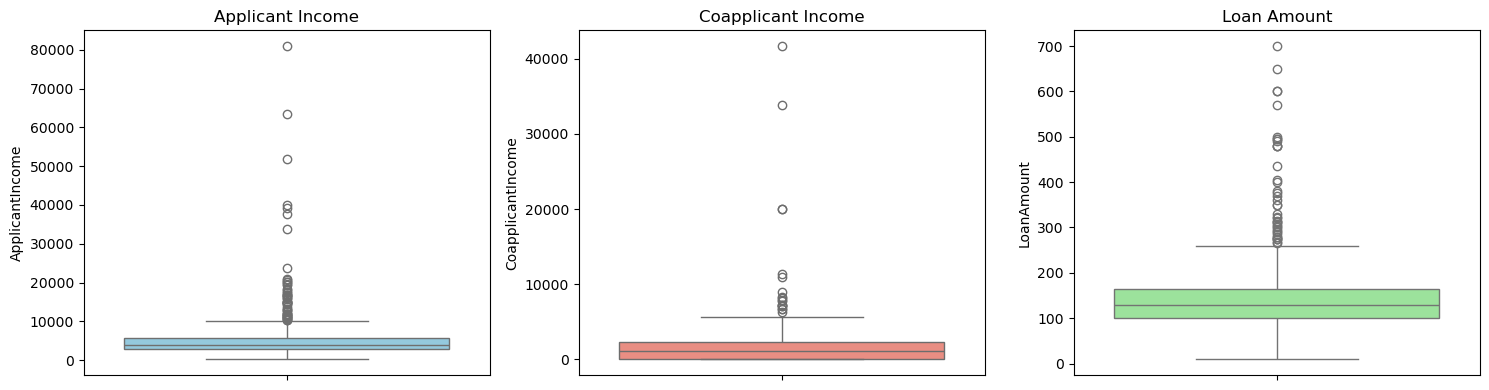

In [38]:
# visualize outliers with boxplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(data=df, y='ApplicantIncome', ax=axes[0], color='skyblue')
axes[0].set_title('Applicant Income')

sns.boxplot(data=df, y='CoapplicantIncome', ax=axes[1], color='salmon')
axes[1].set_title('Coapplicant Income')

sns.boxplot(data=df, y='LoanAmount', ax=axes[2], color='lightgreen')
axes[2].set_title('Loan Amount')

plt.tight_layout()
plt.show()

In [39]:
# cap outliers using IQR method for the skewed columns
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)
    return df

for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']:
    df = cap_outliers(df, col)

print("Outliers capped successfully!")

Outliers capped successfully!


### Step 5: Feature engineering
lets create a new feature TotalIncome by combining applicant and coapplicant income. this makes more sense because banks look at total household income.

In [40]:
# create total income feature
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# also create EMI feature (rough estimate of monthly installment)
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']

# balance income = income left after paying EMI
df['BalanceIncome'] = df['TotalIncome'] - (df['EMI'] * 1000)

print("New features created: TotalIncome, EMI, BalanceIncome")
df.head()

New features created: TotalIncome, EMI, BalanceIncome


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,EMI,BalanceIncome
0,1,0,0,0,0,5849.0,0.0,128.0,360.0,1.0,2,1,5849.0,0.355556,5493.444444
1,1,1,1,0,0,4583.0,1508.0,128.0,360.0,1.0,0,0,6091.0,0.355556,5735.444444
2,1,1,0,0,1,3000.0,0.0,66.0,360.0,1.0,2,1,3000.0,0.183333,2816.666667
3,1,1,0,1,0,2583.0,2358.0,120.0,360.0,1.0,2,1,4941.0,0.333333,4607.666667
4,1,0,0,0,0,6000.0,0.0,141.0,360.0,1.0,2,1,6000.0,0.391667,5608.333333


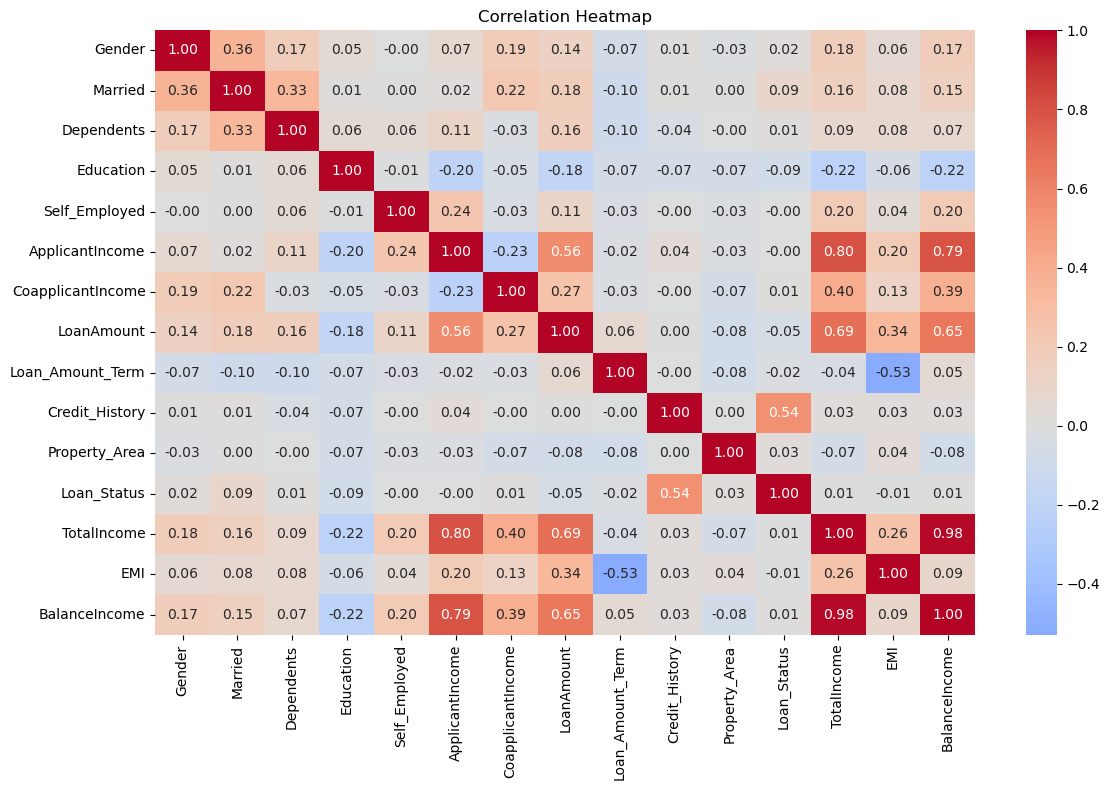

In [41]:
# correlation heatmap to see which features matter most
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

### Split data into features and target

In [42]:
# separate features (X) and target (y)
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

Features shape: (614, 14)
Target distribution:
Loan_Status
1    422
0    192
Name: count, dtype: int64


In [43]:
# split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (491, 14)
Test set: (123, 14)


## Task 3: Pipeline Creation
building a pipeline that combines scaling and the model into one clean workflow.

In [44]:
# create a pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),            # step 1: scale features
    ('classifier', RandomForestClassifier(    # step 2: classify
        n_estimators=100, random_state=42
    ))
])

print("Pipeline created:")
print(pipeline)

Pipeline created:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])


## Task 4: Primary Model Selection

**Why Random Forest?**

i chose Random Forest Classifier because:
1. this is a **binary classification** problem (approved/not approved)
2. Random Forest handles **mixed feature types** well (both numerical and encoded categorical)
3. its **robust to outliers** - even after capping, some noise might remain
4. it **doesnt overfit easily** compared to a single decision tree
5. it gives us **feature importance** so we can see what matters most for loan approval
6. works well with **relatively small datasets** like ours (615 rows)

## Task 5: Model Training
training the model using the pipeline on our training data.

In [45]:
# fit the pipeline on training data
pipeline.fit(X_train, y_train)

# quick check on training accuracy
train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

Training Accuracy: 1.0000


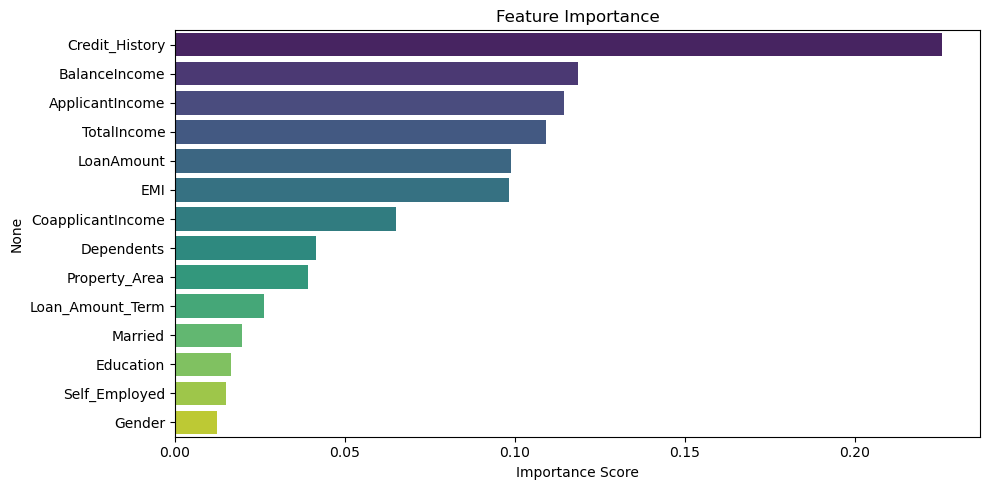

In [46]:
# check feature importance from the random forest
feature_imp = pd.Series(
    pipeline.named_steps['classifier'].feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=feature_imp.values, y=feature_imp.index, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

## Task 6: Cross-Validation
using 5-fold cross validation to check how consistent the model performs across different splits.

In [47]:
# 5-fold cross validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print("Cross-Validation Results (5-Fold):")
print(f"Individual fold scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")
print(f"\nThis means the model is fairly consistent across different splits.")

Cross-Validation Results (5-Fold):
Individual fold scores: [0.76767677 0.74489796 0.78571429 0.7755102  0.74489796]
Mean accuracy: 0.7637
Standard deviation: 0.0164

This means the model is fairly consistent across different splits.


## Task 7: Hyperparameter Tuning
using GridSearchCV to find the best combination of hyperparameters for our Random Forest.

In [48]:
# define parameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# run grid search with 5-fold CV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters found: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best cross-validation accuracy: 0.7964


In [49]:
# show top 10 parameter combinations
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
top_results = top_results.sort_values('rank_test_score').head(10)
print("Top 10 parameter combinations:")
top_results

Top 10 parameter combinations:


,params,mean_test_score,std_test_score,rank_test_score
16,"{'classifier__max_depth': 5, 'classifier__min_...",0.796351,0.010810,1
15,"{'classifier__max_depth': 5, 'classifier__min_...",0.796351,0.010810,1
96,"{'classifier__max_depth': None, 'classifier__m...",0.796331,0.011208,3
53,"{'classifier__max_depth': 10, 'classifier__min...",0.794310,0.011631,4
104,"{'classifier__max_depth': None, 'classifier__m...",0.794310,0.011631,4
102,"{'classifier__max_depth': None, 'classifier__m...",0.794310,0.011631,4
101,"{'classifier__max_depth': None, 'classifier__m...",0.794310,0.011631,4
99,"{'classifier__max_depth': None, 'classifier__m...",0.794310,0.011631,4
80,"{'classifier__max_depth': 15, 'classifier__min...",0.794310,0.011631,4
77,"{'classifier__max_depth': 15, 'classifier__min...",0.794310,0.011631,4


## Task 8: Best Model Selection
selecting the best model from hyperparameter tuning and using it going forward.

In [50]:
# get the best model from grid search
best_model = grid_search.best_estimator_

print("Best Model Selected:")
print(best_model)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV Score: {grid_search.best_score_:.4f}")

Best Model Selected:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=50,
                                        random_state=42))])

Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Best CV Score: 0.7964


## Task 9: Model Performance Evaluation
evaluating the best model on the test set to see how it performs on unseen data.

In [51]:
# predict on test set
y_pred = best_model.predict(X_test)

# accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Approved', 'Approved']))

Test Accuracy: 0.8455

Classification Report:
              precision    recall  f1-score   support

Not Approved       0.88      0.58      0.70        38
    Approved       0.84      0.96      0.90        85

    accuracy                           0.85       123
   macro avg       0.86      0.77      0.80       123
weighted avg       0.85      0.85      0.84       123



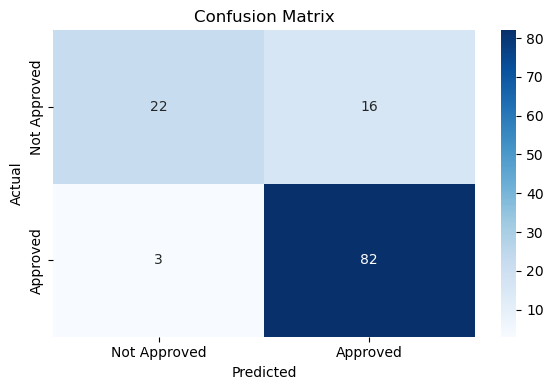

In [52]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [53]:
# ROC AUC score
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_score:.4f}")

ROC AUC Score: 0.8282


## Save the Model
saving the best model so we can use it in the Gradio app later.

In [54]:
# save the trained model pipeline
with open("loan_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# also save the feature names so we can use them in the app
with open("feature_names.pkl", "wb") as f:
    pickle.dump(list(X.columns), f)

print("Model saved as loan_model.pkl")
print("Feature names saved as feature_names.pkl")

Model saved as loan_model.pkl
Feature names saved as feature_names.pkl


## Task 11: Deployment to Hugging Face

**Steps to deploy on Hugging Face Spaces:**

1. Create a new Space on [huggingface.co/spaces](https://huggingface.co/spaces) with **Gradio** SDK
2. Upload these files to the Space:
   - `app.py` (the gradio app code)
   - `loan_model.pkl` (saved model)
   - `feature_names.pkl` (feature names)
   - `requirements.txt` (with scikit-learn, gradio, pandas, numpy)
3. The Space will automatically build and give a public URL

**Note:** I will deploy this manually later to my Hugging Face account.